In [25]:
import sys
sys.path.append('../')
import os
import re
import ROOT
from ROOT import TH1D

import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import uproot

from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents import NanoAODSchema
from coffea import processor, hist
NanoAODSchema.warn_missing_crossrefs = True # no strict cross-references gives warning !

In [26]:
%%cpp
TH1D fill_histo(std::vector<double> values, int n_bins, double v_min, double v_max){
    TH1D histo("h", "", n_bins, v_min, v_max);
    for (int i=0; i<values.size(); i++){
        histo.Fill(values.at(i));
    }
    return histo;
};

In [27]:
%%cpp
TH2D fill_2d_histo(std::vector<double> x_values, std::vector<double> y_values, int n_xbins, double x_min, double x_max, int n_ybins, double y_min, double y_max){
    TH2D histo("h", "", n_xbins, x_min, x_max, n_ybins, y_min, y_max);
    for (int i=0; i<x_values.size(); i++){
        histo.Fill(x_values.at(i), y_values.at(i));
    }
    return histo;
};

In [28]:
def set_hist2d_style(h2, title, title_x, title_y):
    h2.GetYaxis().SetTitle(title_y)
    h2.GetYaxis().SetLabelSize(0.05)
    h2.GetYaxis().SetTitleSize(0.05)
    h2.GetYaxis().SetTitleOffset(1.2)
    
    h2.GetXaxis().SetTitle(title_x)
    h2.GetXaxis().SetLabelSize(0.05)
    h2.GetXaxis().SetTitleSize(0.05)
    h2.GetXaxis().SetTitleOffset(1.2)
    
    return h2

In [73]:
file_path = "/Users/mascella/cernbox/disp_muons/disp_muons_HNL1_svFix.root"
events = NanoEventsFactory.from_root(file_path, schemaclass=NanoAODSchema).events()
events["index"] = ak.Array(range(0, len(events)))
events.index

<Array [0, 1, 2, 3, ... 249997, 249998, 249999] type='250000 * int64'>

(array([23797., 24222., 24343., 23959., 24117., 23776., 23499., 23677.,
        24041., 24119.]),
 array([-3.1416016 , -2.5132813 , -1.8849609 , -1.2566407 , -0.62832034,
         0.        ,  0.62832034,  1.2566407 ,  1.8849609 ,  2.5132813 ,
         3.1416016 ], dtype=float32),
 <BarContainer object of 10 artists>)

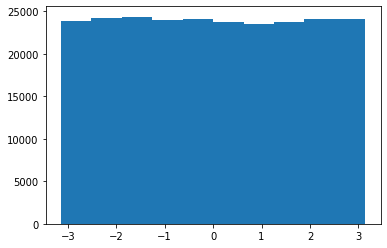

In [41]:
plt.hist(np.array(ak.flatten(events.DSAMuon.phi, axis=-1)))

In [30]:
hnl_muons = events.GenPart[(np.abs(events.GenPart.pdgId) == 13) & (events.GenPart.status == 1) & (
                events.GenPart.distinctParentIdxG != -1)]
print(len(events))
events["gen_muon"] = hnl_muons[hnl_muons.distinctParent.pdgId == 9900012]
print(sum(ak.num(events["gen_muon"].pt, axis=-1)==2))

250000
82078


In [6]:
gen_muons = events.GenPart[(np.abs(events.GenPart.pdgId) == 13) & (events.GenPart.status == 1) & (
                events.GenPart.distinctParentIdxG != -1)]
print(len(events))
events["gen_muons"] = gen_muons[gen_muons.distinctParent.pdgId > 1e4]
print(sum(ak.num(events["gen_muons"].pt, axis=-1)==2))
ak.sum(events.gen_muons.vy[:, 0] == events.gen_muons.vy[:, 1])
print(events.gen_muons.vy[:, 0])

15000
15000
[-96.5, -73.2, -187, 351, -309, -277, 58.1, ... -41.5, 4.36, -256, -166, -0.893, 224]


[[-3.86], [7.58], [0.208], [-18.1], ... [-5.66], [0.619], [-27.1], [-1.34]]
20130


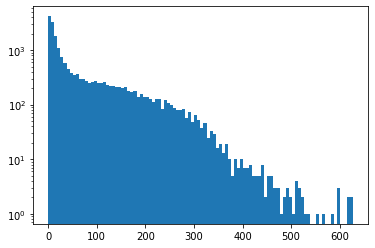

1:227:226293,1:228:227154,1:178:177175,1:179:178121,1:179:178591,1:182:181715,1:142:141616,1:147:146735,1:191:190338,1:162:161236,1:162:161846,1:165:164583,1:103:102112,1:104:103555,1:201:200142,1:61:60332,1:218:217340,1:218:217943,1:34:33022,1:248:247632,1:171:170650,1:175:174757,1:4:3358,1:83:82953,1:84:83827,1:85:84234,1:85:84998,1:186:185007,
28
28


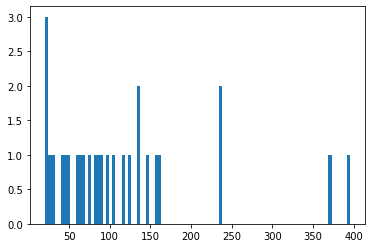

In [31]:
dimuons = events.DiDSAMuon
events_dimuons = events[ak.num(dimuons, axis=-1)>0]
# take only events with at least 1 dimuon
dimuons = dimuons[ak.num(dimuons, axis=-1)>0]
dimuons = dimuons[ak.argmax(dimuons.pt, axis=-1, keepdims=True)]
x = dimuons.vtx_x
y = dimuons.vtx_y
ex = dimuons.vtx_ex
ey = dimuons.vtx_ey

print(x)
print(len(ak.flatten(x, axis=-1)))

dxy = np.sqrt(x**2 + y**2)
dxy_err = np.sqrt(x**2 * ex**2 + y**2 * ey**2) / dxy
dxy_sig = dxy/dxy_err

events_dimuons = events_dimuons[ak.flatten(dxy_err, axis=-1) > 90]
dxy_high = dxy[ak.flatten(dxy_err, axis=-1) > 90]
dxy_err_high = dxy_err[ak.flatten(dxy_err, axis=-1) > 90]

plt.hist(ak.flatten(dxy, axis=-1), bins=100) #, weights=ak.flatten(weight, axis=-1))
plt.yscale("log")
plt.show()
for i in range(len(dxy_high)):
    print(f"{events_dimuons.run[i]}:{events_dimuons.luminosityBlock[i]}:{events_dimuons.event[i]},", end="") #, dxy_high[i], ak.flatten(dxy_err_high, axis=-1)[i])
print()
print(len(events_dimuons))
print(len(dxy_high))
plt.hist(ak.flatten(dxy_high, axis=-1), bins=100)
plt.show()

In [39]:
from array import array
sv_prob_cut = 1e-3
dxy_flat = array("d", ak.flatten(dxy[dimuons.svprob>sv_prob_cut], axis=-1))
dxy_err_flat = array("d", ak.flatten(dxy_err[dimuons.svprob>sv_prob_cut], axis=-1))
dxy_sig_flat = array("d", ak.flatten(dxy_sig[dimuons.svprob>sv_prob_cut], axis=-1))
# dxy_flat = array("d", ak.flatten(dxy, axis=-1))
# dxy_err_flat = array("d", ak.flatten(dxy_err, axis=-1))

In [40]:
c = ROOT.TCanvas("c","", 1)
hist = ROOT.fill_2d_histo(dxy_flat, dxy_err_flat, 100, 0, 500, 100, 0, 120)
hist.SetStats(0)
hist.Draw("colz")
ROOT.gPad.SetLogz()
# hist.GetXaxis().SetTitle("L_{xy} [cm]")
# hist.GetYaxis().SetTitle("#sigma_{L_{xy}} [cm]")
hist = set_hist2d_style(hist, "", "L_{xy} [cm]", "#sigma_{L_{xy}} [cm]")
ROOT.gPad.SetLeftMargin(0.2)
ROOT.gPad.SetBottomMargin(0.2)

# c.Draw()
c.Print("221017_svFix_dxy_sig_VS_dxy_HNL1_probCut_1e-3.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file 221017_svFix_dxy_sig_VS_dxy_HNL1_probCut_1e-3.pdf has been created


In [12]:
c = ROOT.TCanvas()
hist = ROOT.fill_histo(dxy_sig_flat, 100, 0, 80)
# hist.SetStats(0)
hist.Draw()
hist.GetYaxis().SetTitle("counts")
hist.GetXaxis().SetTitle("L_{xy}/#sigma_{L_{xy}}")
hist.GetXaxis().SetTitleOffset(1.3)
ROOT.gPad.SetLogy()

c.Draw()
# c.Print("dxy_sig_HNLm1_prob5.pdf")

NameError: name 'dxy_sig_flat' is not defined

In [35]:
sv_prob_cut = 1e-5
hnl = events.GenPart[events.GenPart.pdgId == 9900012] 
print(len(hnl))
hnl_muon = events.GenPart[(np.abs(events.GenPart.pdgId) == 13) & (events.GenPart.status == 1) & (
                        events.GenPart.distinctParentIdxG != -1)]
hnl_muon = hnl_muon[hnl_muon.distinctParent.pdgId == 9900012]
print(hnl_muon.pt)
hnl_events = events[ak.num(hnl_muon.pt, axis=-1)>1]
print(len(hnl_events))
hnl_dimuons = hnl_events.DiDSAMuon
hnl_dimuons = hnl_dimuons[ak.num(hnl_dimuons, axis=-1)>0]
# hnl_dimuons = hnl_dimuons[ak.argmax(hnl_dimuons.pt, axis=-1, keepdims=True)]

print(len(hnl_dimuons))
x = hnl_dimuons.vtx_x
y = hnl_dimuons.vtx_y
dxy = np.sqrt(x**2 + y**2)

den = dxy
num = dxy[hnl_dimuons.svprob>sv_prob_cut]
print(ak.sum(ak.num(dxy, axis=-1)))
# ak.sum(hnl_dimuons.svprob<0.05)

18750
[[19], [1.51, 16.2], [19.8, 16.4], [10, ... 5.2, 2.09], [22], [13.1], [14.2, 27.5]]
10149
8335
11604


(array([1.338e+03, 1.569e+03, 9.690e+02, 7.100e+02, 5.350e+02, 4.310e+02,
        4.130e+02, 3.810e+02, 3.250e+02, 3.400e+02, 3.180e+02, 3.010e+02,
        2.670e+02, 2.570e+02, 2.490e+02, 2.640e+02, 2.310e+02, 2.150e+02,
        1.940e+02, 1.740e+02, 1.650e+02, 1.750e+02, 1.590e+02, 1.510e+02,
        1.450e+02, 1.510e+02, 1.150e+02, 1.120e+02, 8.900e+01, 7.000e+01,
        6.500e+01, 7.300e+01, 4.000e+01, 2.800e+01, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
        330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
        440., 450., 460., 470., 480., 490., 500.], dtype=float32),
 <BarContaine

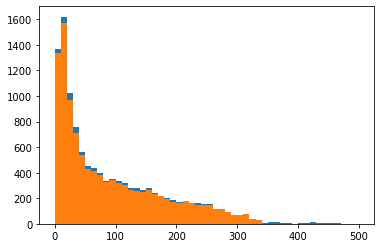

In [36]:
plt.hist(ak.flatten(den, axis=-1), bins=50, range=[0, 500])
plt.hist(ak.flatten(num, axis=-1), bins=50, range=[0, 500])

In [42]:
num = array("d", ak.flatten(num, axis=-1))
den = array("d", ak.flatten(den, axis=-1))
c = ROOT.TCanvas("c2", "", 1)
hist_num = ROOT.fill_histo(num, 50, 0, 500)
hist_den = ROOT.fill_histo(den, 50, 0, 500)
ratio = ROOT.TGraphAsymmErrors()
ratio.Divide(hist_num, hist_den)
ratio.SetLineColor(ROOT.kBlue)
ratio.SetMarkerColor(ROOT.kBlue)
# hist.SetStats(0)
ratio = set_hist2d_style(ratio, "", "L_{xy} [cm]", "Efficiency")
ratio.Draw()
ROOT.gPad.SetLeftMargin(0.2)
ROOT.gPad.SetBottomMargin(0.2)

# c.Draw()
c.Print("sv_eff_recoLxy.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 2 points have been skipped
Info in <TCanvas::Print>: pdf file sv_eff_recoLxy.pdf has been created


In [42]:
def dphi(a, b):
    dphi = (a - b + np.pi) % (2 * np.pi) - np.pi
    return dphi

In [65]:
dphi(1.7 * np.pi, 0)

-0.9424777960769379